#Importing Libraries


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
from pandas import DataFrame
import pandas_datareader as web
import keras
import plotly.graph_objects as go
import tensorflow as tf
import pandas as pd
import itertools
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,LSTM
from __future__ import absolute_import,division,print_function
import os
import math

In [ ]:
## reading the dataset
train_data=pd.read_csv('/content/Japan_cities_rainfall.csv')
to_predict=pd.read_csv('/content/rainfall_to_predict.csv')

# making a copy of original datset 
train_data_original=train_data
to_predict_original=to_predict

In [ ]:
train_data.head() #looking at the head of train data

,date_time,place,longitude,latitude,rainfall
0,20200918_080000,Naha,127.686667,26.206667,0.0
1,20200918_080000,Fukuoka,130.375000,33.581667,0.0
2,20200918_080000,Sendai,140.896667,38.261667,0.0
3,20200918_080000,Osaka,135.518333,34.681667,0.0
4,20200918_080000,Nigata,139.018333,37.893333,3.0


In [ ]:
train_data.dtypes # checking for data types in the train data

date_time     object
place         object
longitude    float64
latitude     float64
rainfall     float64
dtype: object

In [ ]:
## we shall make the date_time column to pandas datetime 
train_data['date_time'] = pd.to_datetime(train_data['date_time'],format='%Y%m%d_%H%M%S')

In [ ]:
train_data.dtypes
## now date_time has changed to pandas datetime

date_time    datetime64[ns]
place                object
longitude           float64
latitude            float64
rainfall            float64
dtype: object

In [ ]:
# I am going to make six different models for six different cities, so I will make list of everything from city name to city model
place_name = [' Tokyo',' Naha',' Sendai',' Osaka',' Nigata',' Fukuoka']

In [ ]:
#Separarting data according to city name and making a list of the dataframe containing train data for each city
place_list= [
train_data.loc[train_data['place']==' Tokyo'],
train_data.loc[train_data['place']==' Naha'],
train_data.loc[train_data['place']==' Sendai'],
train_data.loc[train_data['place']==' Osaka'],
train_data.loc[train_data['place']==' Nigata'],
train_data.loc[train_data['place']==' Fukuoka']]

In the cell below, I am changing the index to pandas datetime, so that it can become a series based on time and then I dropped the date_time column. 
I also dropped longitude, ltitude and place because longitude & latitude are completely related with place column are of completely zero significance in prediction if we have place value. 
The reason behind the dropping of place column is that I am going to create different model for each city

In [ ]:

for i in place_list:
  i.index = i.date_time
  i.drop(['place','longitude','date_time','latitude'],axis = 1,inplace = True)
  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The data was given at intervals of 30 minutes but some of the intervals were of 60 minutes making it discontinuous      data.                           
So I created  time frames which were missing and declared the rainfall values for them missing.

Now I had to use some imputation technique to impute missing values and I used spline interpolation as values were similiar to its nearby values.

In [ ]:
#creating missing dataframes
x=[]
for i in place_list:
  x.append(i.resample('30min').mean())
place_list = x.copy()

In [ ]:
#installing pyts for spline interpolation
pip install pyts


In [ ]:
#applying spline interpolation
from pyts.preprocessing import InterpolationImputer
imputer = InterpolationImputer()
for i in range(0,6):
  new=place_list[i].rainfall
  new=imputer.transform([new])
  new = new[0].tolist()
  place_list[i]['rainfall'] = new


In [ ]:
# In this cell, I am converting the dataframe to pandas series
x=[]
for i in range(0,6):
  ts=place_list[i]['rainfall']
  x.append(ts)

place_list=x.copy()

In [ ]:
# Here we can check that it has converted to pandas series
type(place_list[0])

pandas.core.series.Series

 Tokyo Rainfall Graph 


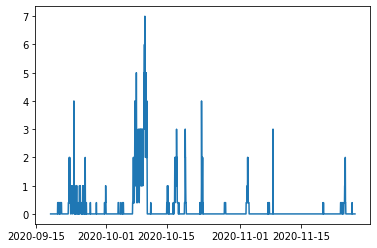

 Naha Rainfall Graph 


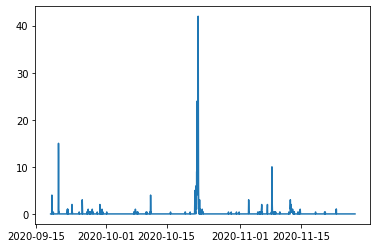

 Sendai Rainfall Graph 


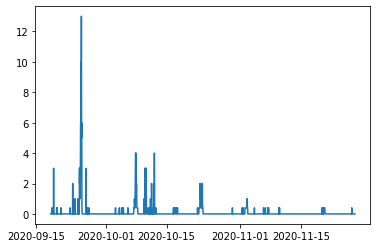

 Osaka Rainfall Graph 


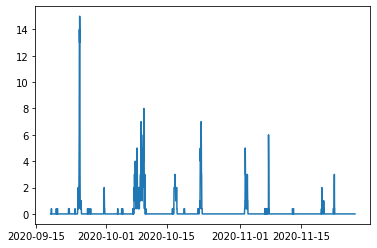

 Nigata Rainfall Graph 


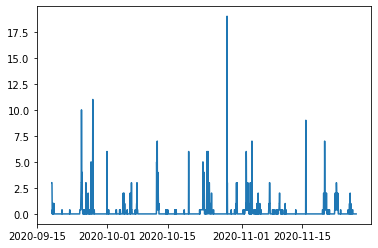

 Fukuoka Rainfall Graph 


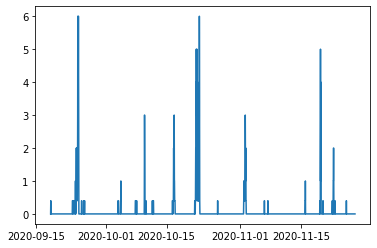

In [ ]:
#Below are the plots of rainfall for each city over time
for i in range(0,6):
  print(place_name[i]+ " Rainfall Graph ")
  plt.plot(place_list[i])
  plt.show()

# Stationarity of a Time Series

A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time. Most of the Time Series models work on the assumption that the Time Series is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:


1.   Constant Mean
2.   Constant Variance
3.   An autocovariance that does not depend on time



###Checking stationarity
Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We will be implementing Dickey-Fuller Test for each city 

Results of Dickey-Fuller Test for  Tokyo


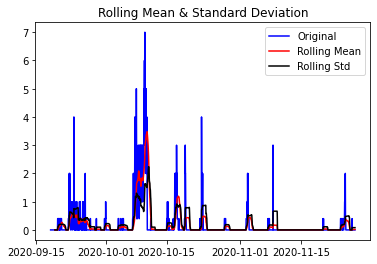

Test Statistic                -5.808652e+00
p-value                        4.454635e-07
#Lags Used                     2.800000e+01
Number of Observations Used    3.334000e+03
Critical Value (1%)           -3.432313e+00
Critical Value (5%)           -2.862407e+00
Critical Value (10%)          -2.567232e+00
dtype: float64
Results of Dickey-Fuller Test for  Naha


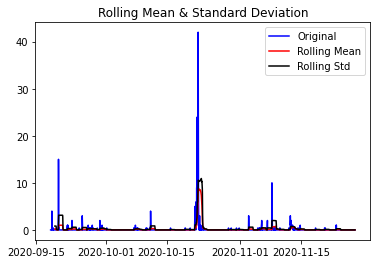

Test Statistic                -7.863219e+00
p-value                        5.216778e-12
#Lags Used                     2.900000e+01
Number of Observations Used    3.332000e+03
Critical Value (1%)           -3.432314e+00
Critical Value (5%)           -2.862408e+00
Critical Value (10%)          -2.567232e+00
dtype: float64
Results of Dickey-Fuller Test for  Sendai


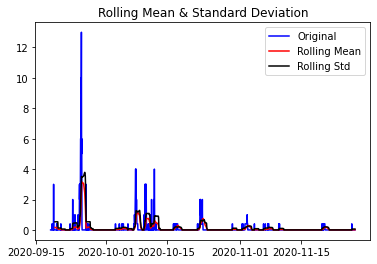

Test Statistic                -8.157864e+00
p-value                        9.314267e-13
#Lags Used                     2.800000e+01
Number of Observations Used    3.334000e+03
Critical Value (1%)           -3.432313e+00
Critical Value (5%)           -2.862407e+00
Critical Value (10%)          -2.567232e+00
dtype: float64
Results of Dickey-Fuller Test for  Osaka


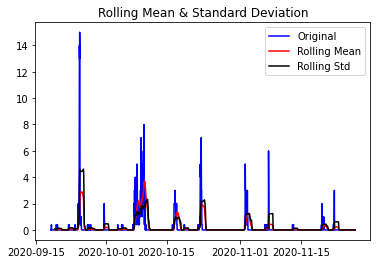

Test Statistic                -7.218974e+00
p-value                        2.136006e-10
#Lags Used                     2.700000e+01
Number of Observations Used    3.335000e+03
Critical Value (1%)           -3.432312e+00
Critical Value (5%)           -2.862407e+00
Critical Value (10%)          -2.567232e+00
dtype: float64
Results of Dickey-Fuller Test for  Nigata


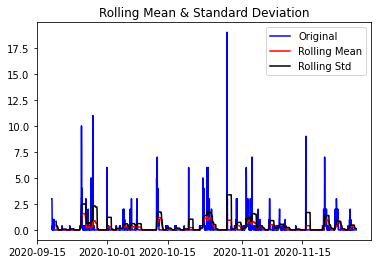

Test Statistic                -1.246585e+01
p-value                        3.327110e-23
#Lags Used                     1.000000e+01
Number of Observations Used    3.352000e+03
Critical Value (1%)           -3.432302e+00
Critical Value (5%)           -2.862403e+00
Critical Value (10%)          -2.567229e+00
dtype: float64
Results of Dickey-Fuller Test for  Fukuoka


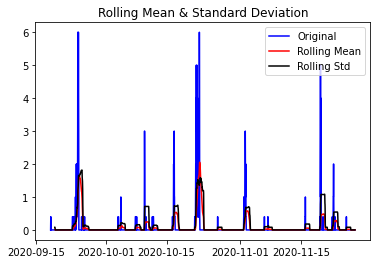

Test Statistic                -8.346165e+00
p-value                        3.081364e-13
#Lags Used                     2.700000e+01
Number of Observations Used    3.335000e+03
Critical Value (1%)           -3.432312e+00
Critical Value (5%)           -2.862407e+00
Critical Value (10%)          -2.567232e+00
dtype: float64


In [165]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(48).mean()
    rolstd = timeseries.rolling(48).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

for i in range(0,6):
  print('Results of Dickey-Fuller Test for '+ place_name[i])
  test_stationarity(place_list[i])

#####Checking Stationarity

By looking at p-values, critical values and test statistic, we can reject the null hypothesis and can say that our series is stationary. So we can directly use the given series.

# Forecasting the Series

We will be using ARIMA model to predict.

ACF and PACF 

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

Below are ACF and PACF plots.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



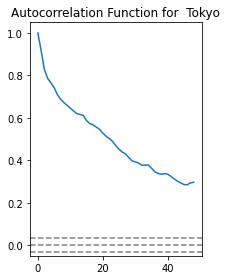

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



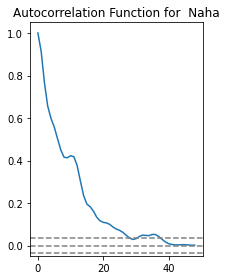

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



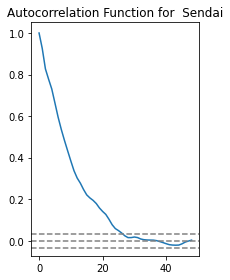

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



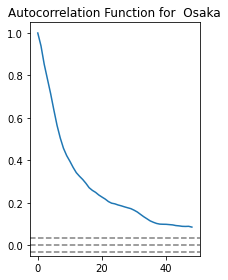

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



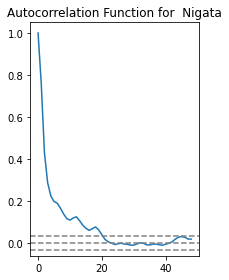

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



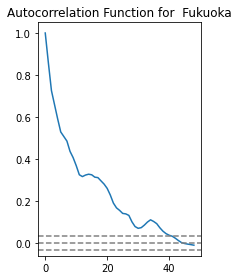

In [ ]:
from statsmodels.tsa.stattools import acf, pacf


for i in range(0,6):
  lag_acf = acf(place_list[i], nlags=48)
  
  plt.subplot(121) 
  plt.plot(lag_acf)
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(place_list[i])),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(place_list[i])),linestyle='--',color='gray')
  plt.title('Autocorrelation Function for '+place_name[i])
  plt.tight_layout()
  plt.show()


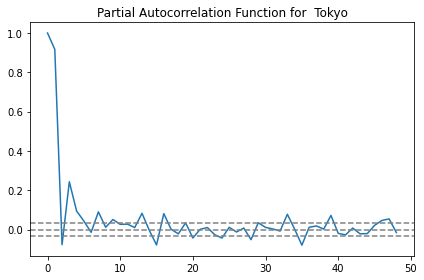

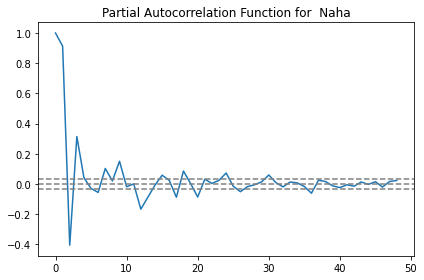

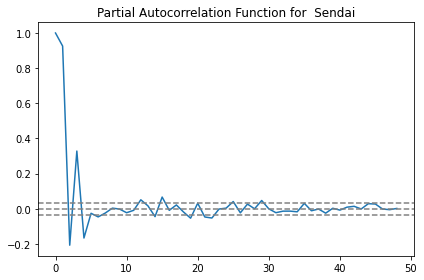

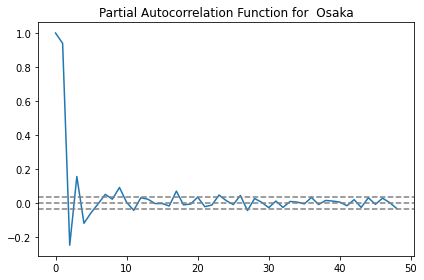

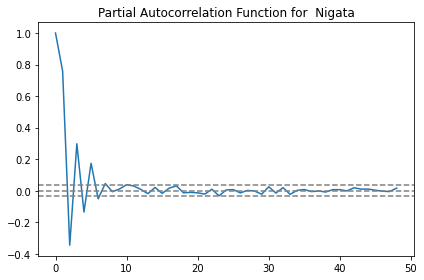

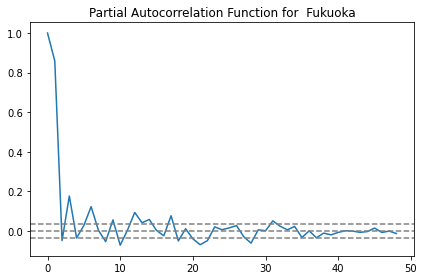

In [ ]:
for i in range(0,6):
  lag_pacf = pacf(place_list[i], nlags=48, method='ols')
  plt.plot(lag_pacf)
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(place_list[i])),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(place_list[i])),linestyle='--',color='gray')
  plt.title('Partial Autocorrelation Function for '+ place_name[i])
  plt.tight_layout()
  plt.show()

#### Applying ARIMA model to each city

MSE is  0.060078393202841


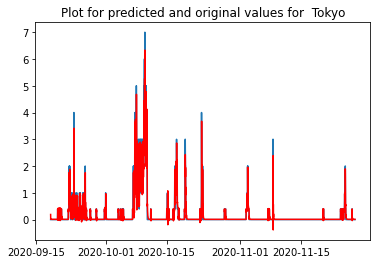

MSE is  0.36351058499745


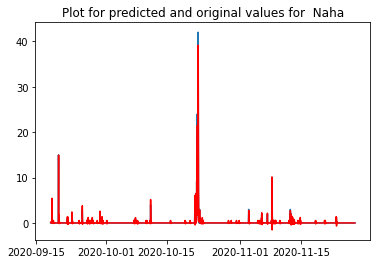

MSE is  0.04950004447053316


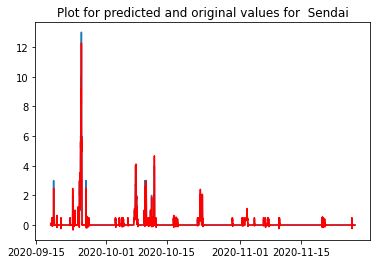

MSE is  0.0980674030047827


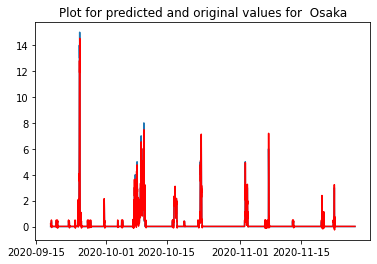

MSE is  0.25652833728972946


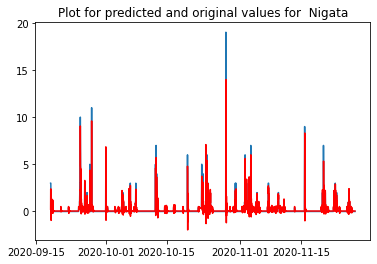

MSE is  0.05422081158821316


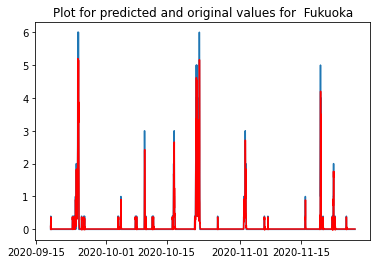

In [ ]:

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
model_ARIMA=[];
for i in range(0,6):
  model = ARIMA(place_list[i], order=(2, 0, 2))  
  
  results_ARIMA = model.fit() 
  model_ARIMA.append(results_ARIMA) 
  plt.plot(place_list[i])
  plt.plot(results_ARIMA.fittedvalues, color='red')
  plt.title('Plot for predicted and original values for '+place_name[i])
  print('MSE is ', mean_squared_error(place_list[i], results_ARIMA.fittedvalues))
  plt.show()
  ##red plot is for fitted values

We can look at mse values for each city

In [166]:
# predicting at particular time for Tokyo
model_ARIMA[0].predict(start='2020-10-27 09:00:00',end='2020-10-27 09:00:00')

date_time
2020-10-27 09:00:00    0.008789
Freq: 30T, dtype: float64

# Predicting for the test dataset 

In [145]:
#we have already loaded the data in to_predict
to_predict.head()

,date_time,place,longitude,latitude,rainfall
0,2020-09-19 01:30:00,Naha,127.686667,26.206667,0
1,2020-09-19 22:30:00,Nigata,139.018333,37.893333,0
2,2020-09-19 23:30:00,Sendai,140.896667,38.261667,0
3,2020-09-20 03:00:00,Fukuoka,130.375000,33.581667,0
4,2020-09-20 13:00:00,Naha,127.686667,26.206667,0


In [146]:
#Here we convert the date_time to pandas datetime object
to_predict['date_time'] = pd.to_datetime(to_predict['date_time'],format='%Y%m%d_%H%M%S')

In [147]:
# Now we can check the data type of date_time column and we can see that it is of datetime type
to_predict.dtypes

date_time    datetime64[ns]
place                object
longitude           float64
latitude            float64
rainfall              int64
dtype: object

In [151]:
#now lets create a rainfall column in it and initialize it to zero
to_predict['rainfall']=0.0

In [152]:
# now lets check head of to_predict and we can see that rainfall column has been added
to_predict.head()

,date_time,place,longitude,latitude,rainfall
0,2020-09-19 01:30:00,Naha,127.686667,26.206667,0.0
1,2020-09-19 22:30:00,Nigata,139.018333,37.893333,0.0
2,2020-09-19 23:30:00,Sendai,140.896667,38.261667,0.0
3,2020-09-20 03:00:00,Fukuoka,130.375000,33.581667,0.0
4,2020-09-20 13:00:00,Naha,127.686667,26.206667,0.0


In [153]:
#now we will predict values of rainfall based on location and time
length_of_datset=len(to_predict.place)
count=0
# I will be using a for loop in which I will check date and select model from the list of the models and ten I will use predict function 
for i in range(length_of_datset):
  for j in range(len(place_name)): # place_name list tells me the index of 
    if to_predict.place[i]==place_name[j]:
      
      s=to_predict.date_time[i]
      e=s
      x=model_ARIMA[j].predict(start=s,end=e)
      x=math.trunc(x[0]*100)/100
      
      to_predict.rainfall[i]=x
      



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



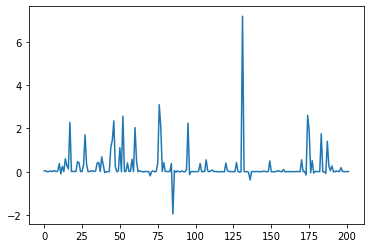

In [154]:
plt.plot(to_predict.rainfall)

In [155]:
#from the above graph we can see that there are some negative values but negative rainfall is not possible so we will replace those negative values with zero
to_predict.rainfall.loc[to_predict.rainfall<=0]=0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



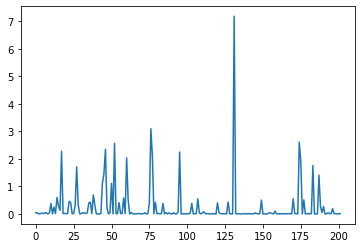

In [156]:
#now we can check that all values are non-negative
plt.plot(to_predict.rainfall)

In [159]:
#now we will save the changes to csv file of the test dataset provided to us
prediction=pd.read_csv('/content/rainfall_to_predict.csv')
prediction['rainfall']=to_predict.rainfall
pd.DataFrame(prediction,columns=['date_time','place','longitude','latitude','rainfall']).to_csv("/content/predicted_rainfall.csv",index=False)

In [162]:
# I will be uploading this predicted excel sheet on GitHub 
# we can use forecast function in ARIMA model to predict future values outside the dataset
# For example , if we want to predict one step out of the sample for Tokyo City
model_ARIMA[0].forecast()[0]

array([0.00879974])

# For prediction according to the input from user


In [164]:
place=input('Please write the name of the place name : ')
time=input('Please write Date and Time in format YYmmdd_HHMMSS : ')
#first we will change this time to pandas datetime object
time_new=pd.to_datetime(time,format='%Y%m%d_%H%M%S')
place=" "+place
# now we will look for the model for a particular city in the model list
for i in range(0,6):
  if place_name[i]==place:
    x=model_ARIMA[j].predict(start=time_new,end=time_new)
    x=math.trunc(x[0]*100)/100
    print('Rainfall will be : ',x)

Please write the name of the place name : Tokyo
Please write Date and Time in format YYmmdd_HHMMSS : 20200922_203000
Rainfall will be :  0.01


In [ ]:
# we can see that it predicted rainfall for values recieved from the user